In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import datetime
from datetime import datetime

In [2]:
# Load Data
training_set = pd.read_csv('data.csv')

/Users/yao-chiehhu/miniconda3/envs/env_pytorch/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
training_set.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016/8/9,1464,106,415,31680,...,1,2005,3,6,0.217,1,0,1,7,56021
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016/7/28,903,126,575,43436,...,1,2004,4,6,0.667,1,1,0,7,71539
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016/12/11,1271,48,1030,52021,...,4,2009,3,6,0.500,1,0,0,7,48160
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016/9/30,965,138,298,22202,...,1,2008,1,6,0.273,1,0,0,6,51238
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016/8/28,927,286,392,48396,...,4,1960,2,2,0.333,0,1,1,1,62588


- id: the id of transaction
- Lng and Lat coordinates
- Cid: community id
- tradeTime: the time of transaction
- DOM: active days on market. (Know more in https://en.wikipedia.org/wiki/Days_on_market)
- followers: the number of people following the transaction
- totalPrice: the total price
- price: the average price by square
- square: the square of house
- bedroom: The number of bedrooms
- livingRoom: the number of living room
- kitchen: the number of kitchen
- bathroom: the number of bathroom
- floor: the height of the house
- buildingType: including (1)tower (2) bungalow (3)combination of plate and tower (4)plate (5) Unknown
- constructionTime: the time of construction
- renovationCondition: including (1) other (2) rough (3) Simple (4) refined decoration
- buildingStructure: including (1) unknow (2) mixed (3) brick and wood (4) brick and concrete (5) steel (6)steel-concrete composite
- ladderRatio: (#residents living in one floor) / (#elevators)
- elevator: Whether there is an elevator in the building
- fiveYearsProperty: whether the owner owns the property for less than 5 years
- Subway: Whether there is a subway station in the neighborhood
- district: Different administrative districts in Beijing
- communityAverage: Average Prcie in the community

In [4]:
# Convert Datetime to timestamp
training_set["timestamp"] = training_set["tradeTime"].apply(lambda x: datetime.timestamp(datetime.strptime(x, "%Y/%m/%d")))


In [5]:
# Get year month date day
training_set["year"] = training_set["tradeTime"].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").year)
training_set["month"] = training_set["tradeTime"].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").month)
training_set["day"] = training_set["tradeTime"].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").day)
training_set["weekday"] = training_set["tradeTime"].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").weekday())

In [6]:
# Sort by timestamp
training_set = training_set.sort_values(by=['timestamp'])

In [7]:
# Drop columns
training_set = training_set.drop(columns=["url","id","tradeTime"])

In [8]:
training_set.head()

,Lng,Lat,Cid,DOM,followers,totalPrice,price,square,bedroom,livingroom,...,elevator,fiveYearsProperty,subway,district,communityAverage,timestamp,year,month,day,weekday
94300,116.386555,40.086500,1111027382546,1,0,153,17053,89,2,2,...,1,0,0,6,47574,1.022861e+09,2002,6,1,5
126754,116.482331,40.014156,1111027380302,1,0,325,27041,120,3,1,...,1,1,1,7,65595,1.025885e+09,2002,7,6,5
126582,116.603501,39.919667,1111027377416,1,0,186,14210,131,3,1,...,1,0,1,7,43307,1.026230e+09,2002,7,10,2
223180,116.299198,39.838131,1111027380071,1,0,161,26923,60,2,1,...,1,0,1,2,48853,1.059581e+09,2003,7,31,3
92998,116.330198,40.074228,1111027381003,1,0,126,22195,57,1,1,...,1,0,1,6,50205,1.223309e+09,2008,10,7,1


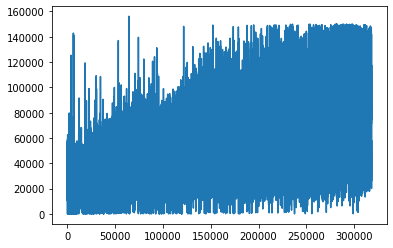

In [9]:
# Plot price & timestamp
training_set_price = training_set.loc[:,"price"].values

plt.plot(training_set_price, label = 'Housing Price Data')
plt.show()

In [10]:
# Sliding windows
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        # Plus 1 to include the exact housing for this one.
        _x = data[i:(i+seq_length+1)]
        # _y = data[i+seq_length]
        _y = data[i+seq_length][6]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [11]:
# Data loading
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [12]:
# Model
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
# Training

num_epochs = 100
learning_rate = 0.01

input_size = 28
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

/Users/yao-chiehhu/miniconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([213094])) that is different to the input size (torch.Size([213094, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()